# Title

In [1]:
from dataset import SOCOFingDataset
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from utils import seed
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tfs
import numpy as np
import seaborn as sns

sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed(42)

In [3]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu")
DEVICE

device(type='cuda', index=0)

## Data prepare

In [4]:
files = sorted(
    list(Path("../SOCOFing/Real").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Easy").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Medium").rglob("*.BMP"))
    + list(Path("../SOCOFing/Altered/Altered-Hard").rglob("*.BMP"))
)

In [5]:
labels = [file.name[0 : file.name.find("_")] for file in files]
train_files, test_files = train_test_split(files, test_size=0.4, stratify=labels)

test_labels = [file.name[0 : file.name.find("_")] for file in test_files]
test_files, val_files = train_test_split(
    test_files, test_size=0.5, stratify=test_labels
)

len(train_files), len(test_files), len(val_files)

(33162, 11054, 11054)

In [6]:
train_dataset = SOCOFingDataset(files, (64, 64), "train")
test_dataset = SOCOFingDataset(files, (64, 64), "test")
val_dataset = SOCOFingDataset(files, (64, 64), "val")

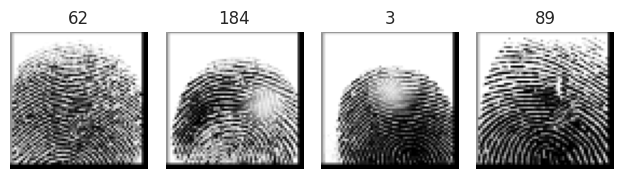

In [7]:
def imshow(dataset, indicies):
    fig, axeslist = plt.subplots(ncols=len(indicies), nrows=1)
    for i in range(len(indicies)):
        image, label = dataset[indicies[i]]
        image = image.numpy().transpose((1, 2, 0))
        axeslist.ravel()[i].imshow(image, cmap=plt.gray())
        axeslist.ravel()[i].set_title(label)
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout()


imshow(train_dataset, np.random.randint(0, 6000, 4))

## Model

In [8]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 600)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [9]:
model = NN(64 * 64).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

## Train

In [10]:
batch_size = 100

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
%%time

best_model = model

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_acc = 0.0

for epoch in range(100):
    # Train stage
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for X, y in train_loader:
        # Setup
        X = X.view(-1, 64 * 64).to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        # Train
        y_pred = model(X)
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        # Evaluate
        train_acc += torch.sum(y.data == torch.argmax(y_pred, 1))

    # Log
    train_acc /= len(train_dataset)
    train_loss_history.append(train_loss.cpu().data)
    train_acc_history.append(train_acc.cpu().data)

    # Eval stage
    model.eval()

    val_loss = 0.0
    val_acc = 0.0

    for X, y in val_loader:
        X = X.view(-1, 64 * 64).to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            y_pred = model(X)
            val_loss = criterion(y_pred, y)
            val_acc += torch.sum(y.data == torch.argmax(y_pred, 1))

    # Log
    val_acc /= len(val_dataset)
    val_loss_history.append(val_loss.cpu().data)
    val_acc_history.append(val_acc.cpu().data)

    # Save if improved
    if train_acc > best_acc:
        best_acc = train_acc
        best_model = model

    print(
        f"Epoch {epoch}, "
        f"train_loss: {train_loss}, "
        f"val_loss: {val_loss}, "
        f"train_acc {train_acc:0.4f}, "
        f"val_acc: {val_acc}"
    )

print("Best accuracy:", best_acc)

Epoch 0, train_loss: 3.5847280025482178, val_loss: 3.1221866607666016, train_acc 0.1780, val_acc: 0.5137868523597717
Epoch 1, train_loss: 1.2294706106185913, val_loss: 1.2015239000320435, train_acc 0.6698, val_acc: 0.8332006931304932
Epoch 2, train_loss: 0.7664788961410522, val_loss: 0.7143723368644714, train_acc 0.8885, val_acc: 0.9310656785964966
Epoch 3, train_loss: 0.3925211727619171, val_loss: 0.11768472194671631, train_acc 0.9548, val_acc: 0.9686991572380066
Epoch 4, train_loss: 0.39573976397514343, val_loss: 0.08732744306325912, train_acc 0.9783, val_acc: 0.9801338911056519
Epoch 5, train_loss: 0.09133503586053848, val_loss: 0.028050463646650314, train_acc 0.9839, val_acc: 0.9865026473999023
Epoch 6, train_loss: 0.10095053911209106, val_loss: 0.011296664364635944, train_acc 0.9888, val_acc: 0.9923104643821716
Epoch 7, train_loss: 0.07335612922906876, val_loss: 0.008659359999001026, train_acc 0.9915, val_acc: 0.9829021096229553
Epoch 8, train_loss: 0.352988064289093, val_loss: 0.

KeyboardInterrupt: 

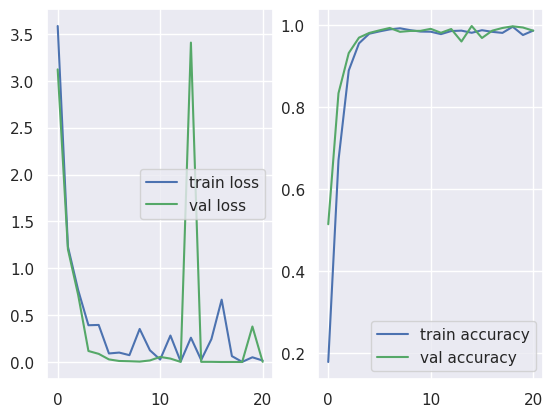

In [15]:
fig, axeslist = plt.subplots(ncols=2, nrows=1)

axeslist.ravel()[0].plot(train_loss_history, "-b", label="train loss")
axeslist.ravel()[0].plot(val_loss_history, "-g", label="val loss")
axeslist.ravel()[0].legend()

axeslist.ravel()[1].plot(train_acc_history, "-b", label="train accuracy")
axeslist.ravel()[1].plot(val_acc_history, "-g", label="val accuracy")
axeslist.ravel()[1].legend()

## Save model

In [17]:
torch.save(best_model.state_dict(), Path("../models/nn_sm_acc_99"))